In [4]:
import os.path as path
import os
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image, ImageOps

In [5]:
DATAROOT = path.expanduser("~/ml-data/plant-pathology")

In [6]:
train_df = pd.read_csv(path.join(DATAROOT, "train.csv"))

In [7]:
train_df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [9]:
train_df.describe()

healthy  multiple_diseases         rust         scab
count  1821.000000        1821.000000  1821.000000  1821.000000
mean      0.283361           0.049973     0.341571     0.325096
std       0.450754           0.217948     0.474367     0.468539
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000

In [10]:
train_df.groupby(train_df.healthy == 1).size() / train_df.shape[0]

healthy
False    0.716639
True     0.283361
dtype: float64

In [11]:
train_df[(train_df.multiple_diseases == 1) & (train_df.scab == 1)]

Empty DataFrame
Columns: [image_id, healthy, multiple_diseases, rust, scab]
Index: []

In [12]:
train_df[(train_df.multiple_diseases == 1) & (train_df.rust == 1)]

Empty DataFrame
Columns: [image_id, healthy, multiple_diseases, rust, scab]
Index: []

In [13]:
train_df.groupby(train_df.multiple_diseases == 1).size() / train_df.shape[0]

multiple_diseases
False    0.950027
True     0.049973
dtype: float64

In [14]:
train_df.groupby(train_df.scab == 1).size() / train_df.shape[0]

scab
False    0.674904
True     0.325096
dtype: float64

In [15]:
train_df.groupby(train_df.rust == 1).size() / train_df.shape[0]

rust
False    0.658429
True     0.341571
dtype: float64

In [43]:
print(train_df[(train_df.rust == 1) & (train_df.healthy == 1)].shape[0] == 0)
print(train_df[(train_df.rust == 1) & (train_df.scab == 1)].shape[0] == 0)
print(train_df[(train_df.rust == 1) & (train_df.multiple_diseases == 1)].shape[0] == 0)

print(train_df[(train_df.scab == 1) & (train_df.healthy == 1)].shape[0] == 0)
print(train_df[(train_df.scab == 1) & (train_df.multiple_diseases == 1)].shape[0] == 0)

print(train_df[(train_df.healthy == 1) & (train_df.multiple_diseases == 1)].shape[0] == 0)


True
True
True
True
True
True


So far we know that this is a multi-class (*not* multi-label) classification problem with the following distribution of classes:

| Label             | Frequency |
| ----------------- | --------- |
| rust              | 34%       |
| scab              | 32%       |
| healthy           | 28%       |
| multiple diseases | 5%        |

In [16]:
img_path = path.join(DATAROOT, "images", "Train_1217.jpg")
img = Image.open(img_path)

In [17]:
img.size

(2048, 1365)

In [18]:
img.mode

'RGB'

In [19]:
widths = []
heights = []
modes = []
imgroot = path.join(DATAROOT, "images")
for img_file in os.listdir(imgroot):
    img_path = path.join(DATAROOT, "images", img_file)
    width, height = Image.open(img_path).size
    widths.append(width)
    heights.append(height)
    modes.append(img.mode)

In [20]:
Counter(widths)

Counter({2048: 3620, 1365: 22})

In [21]:
Counter(heights)

Counter({1365: 3620, 2048: 22})

In [22]:
Counter(modes)

Counter({'RGB': 3642})

In [23]:
imgs = []
for img_file in os.listdir(imgroot):
    img_path = path.join(imgroot, img_file)
    img = Image.open(img_path)
    if img.size == (1365, 2048):
        imgs.append(img)
        if len(imgs) == 5:
            break

In [24]:
len(imgs)

5

In [25]:
imgs[0].size

(1365, 2048)

In [26]:
img = np.asarray(imgs[0])
img.shape

(2048, 1365, 3)

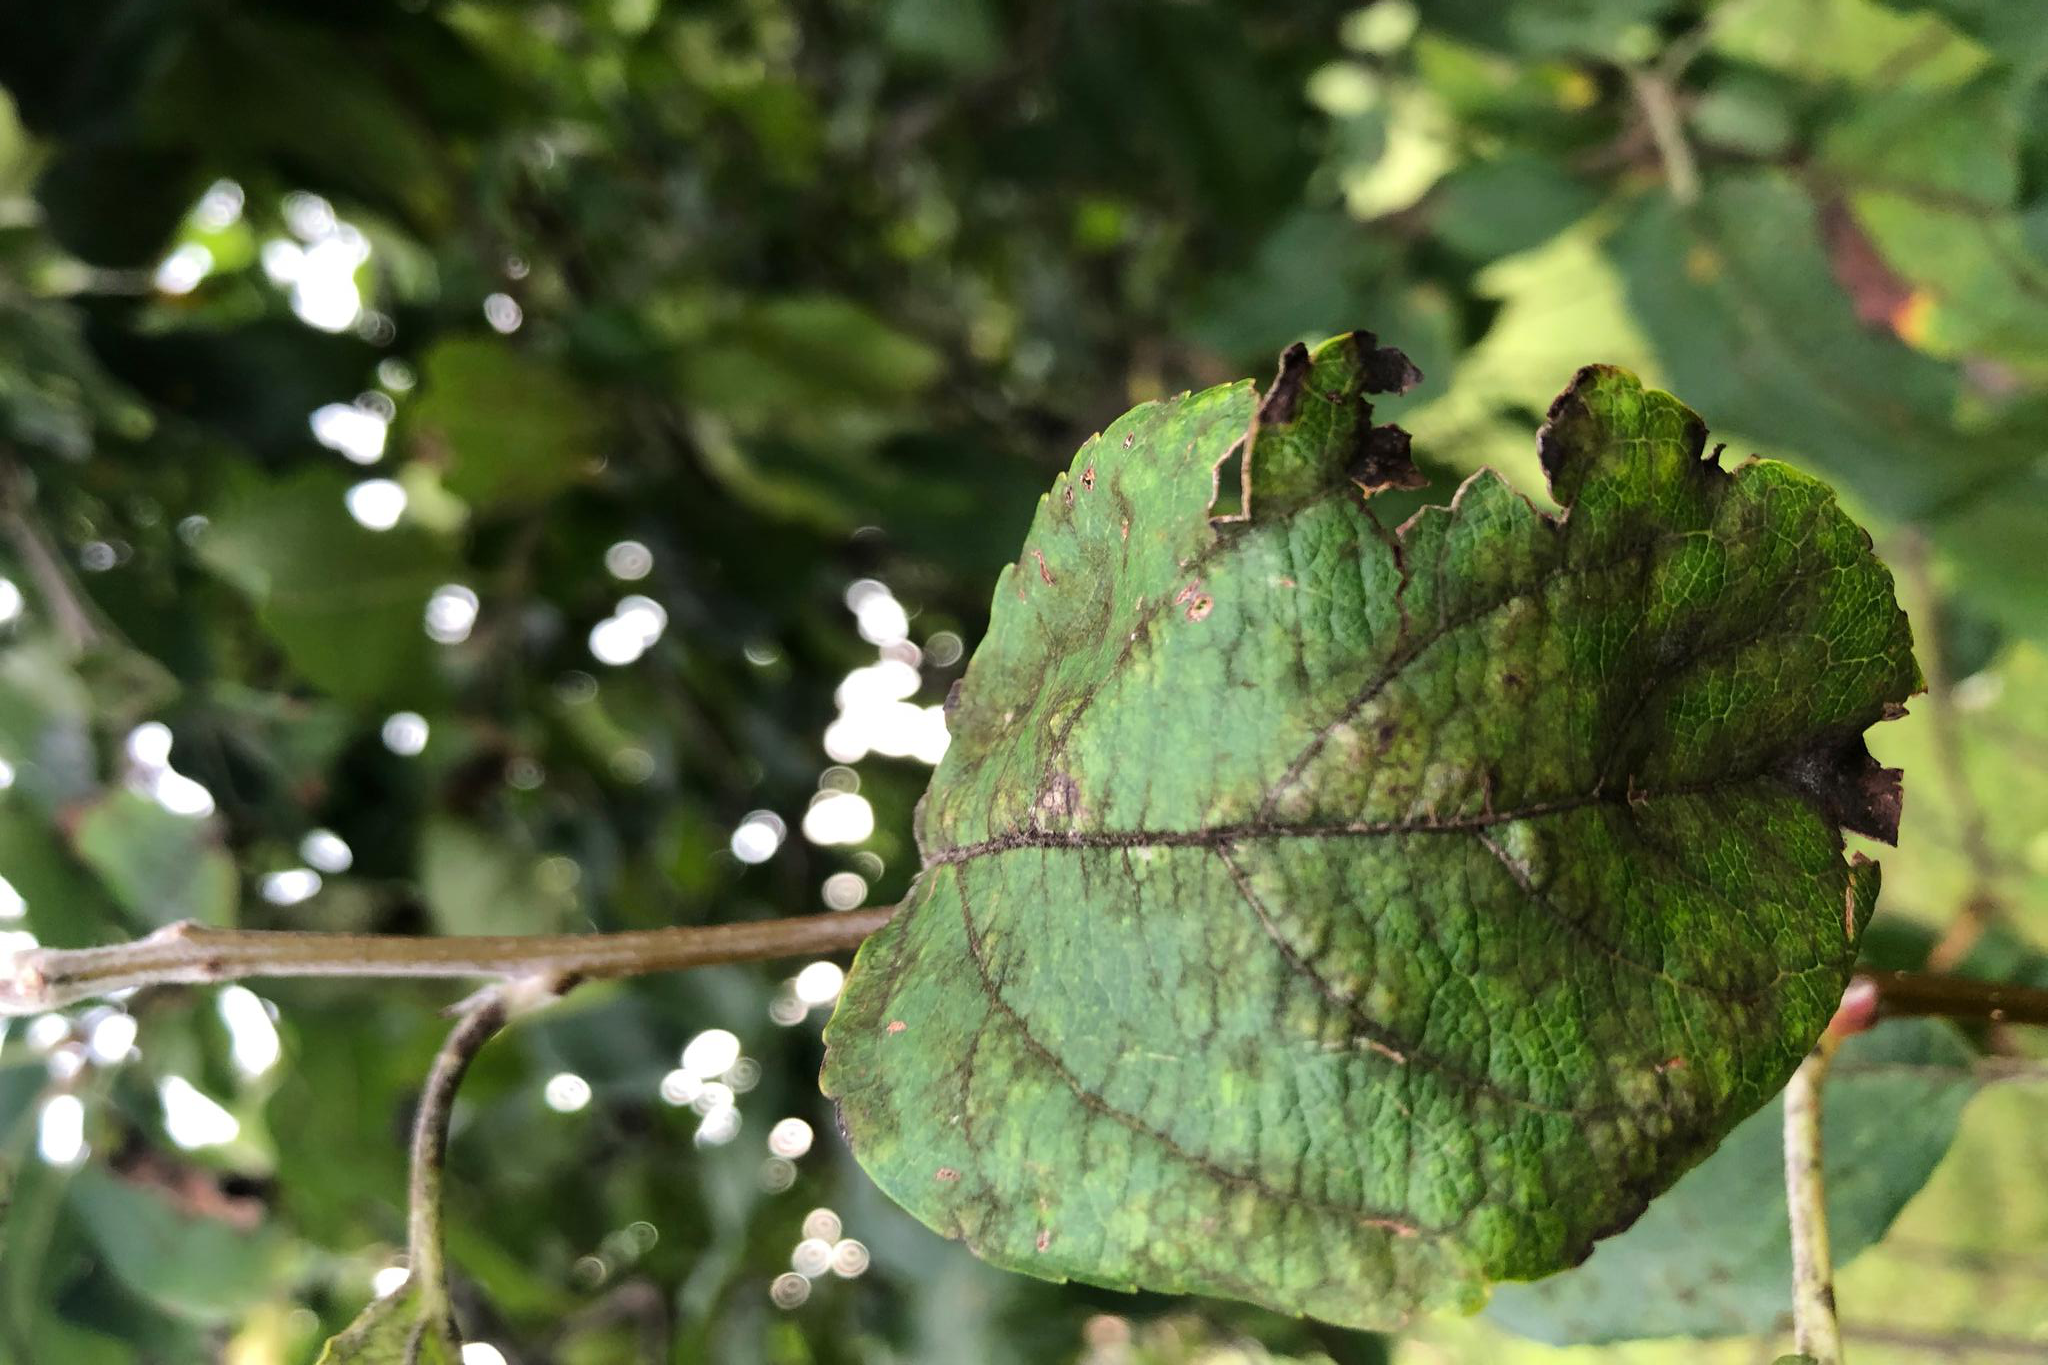

In [27]:
Image.fromarray(np.rot90(img))

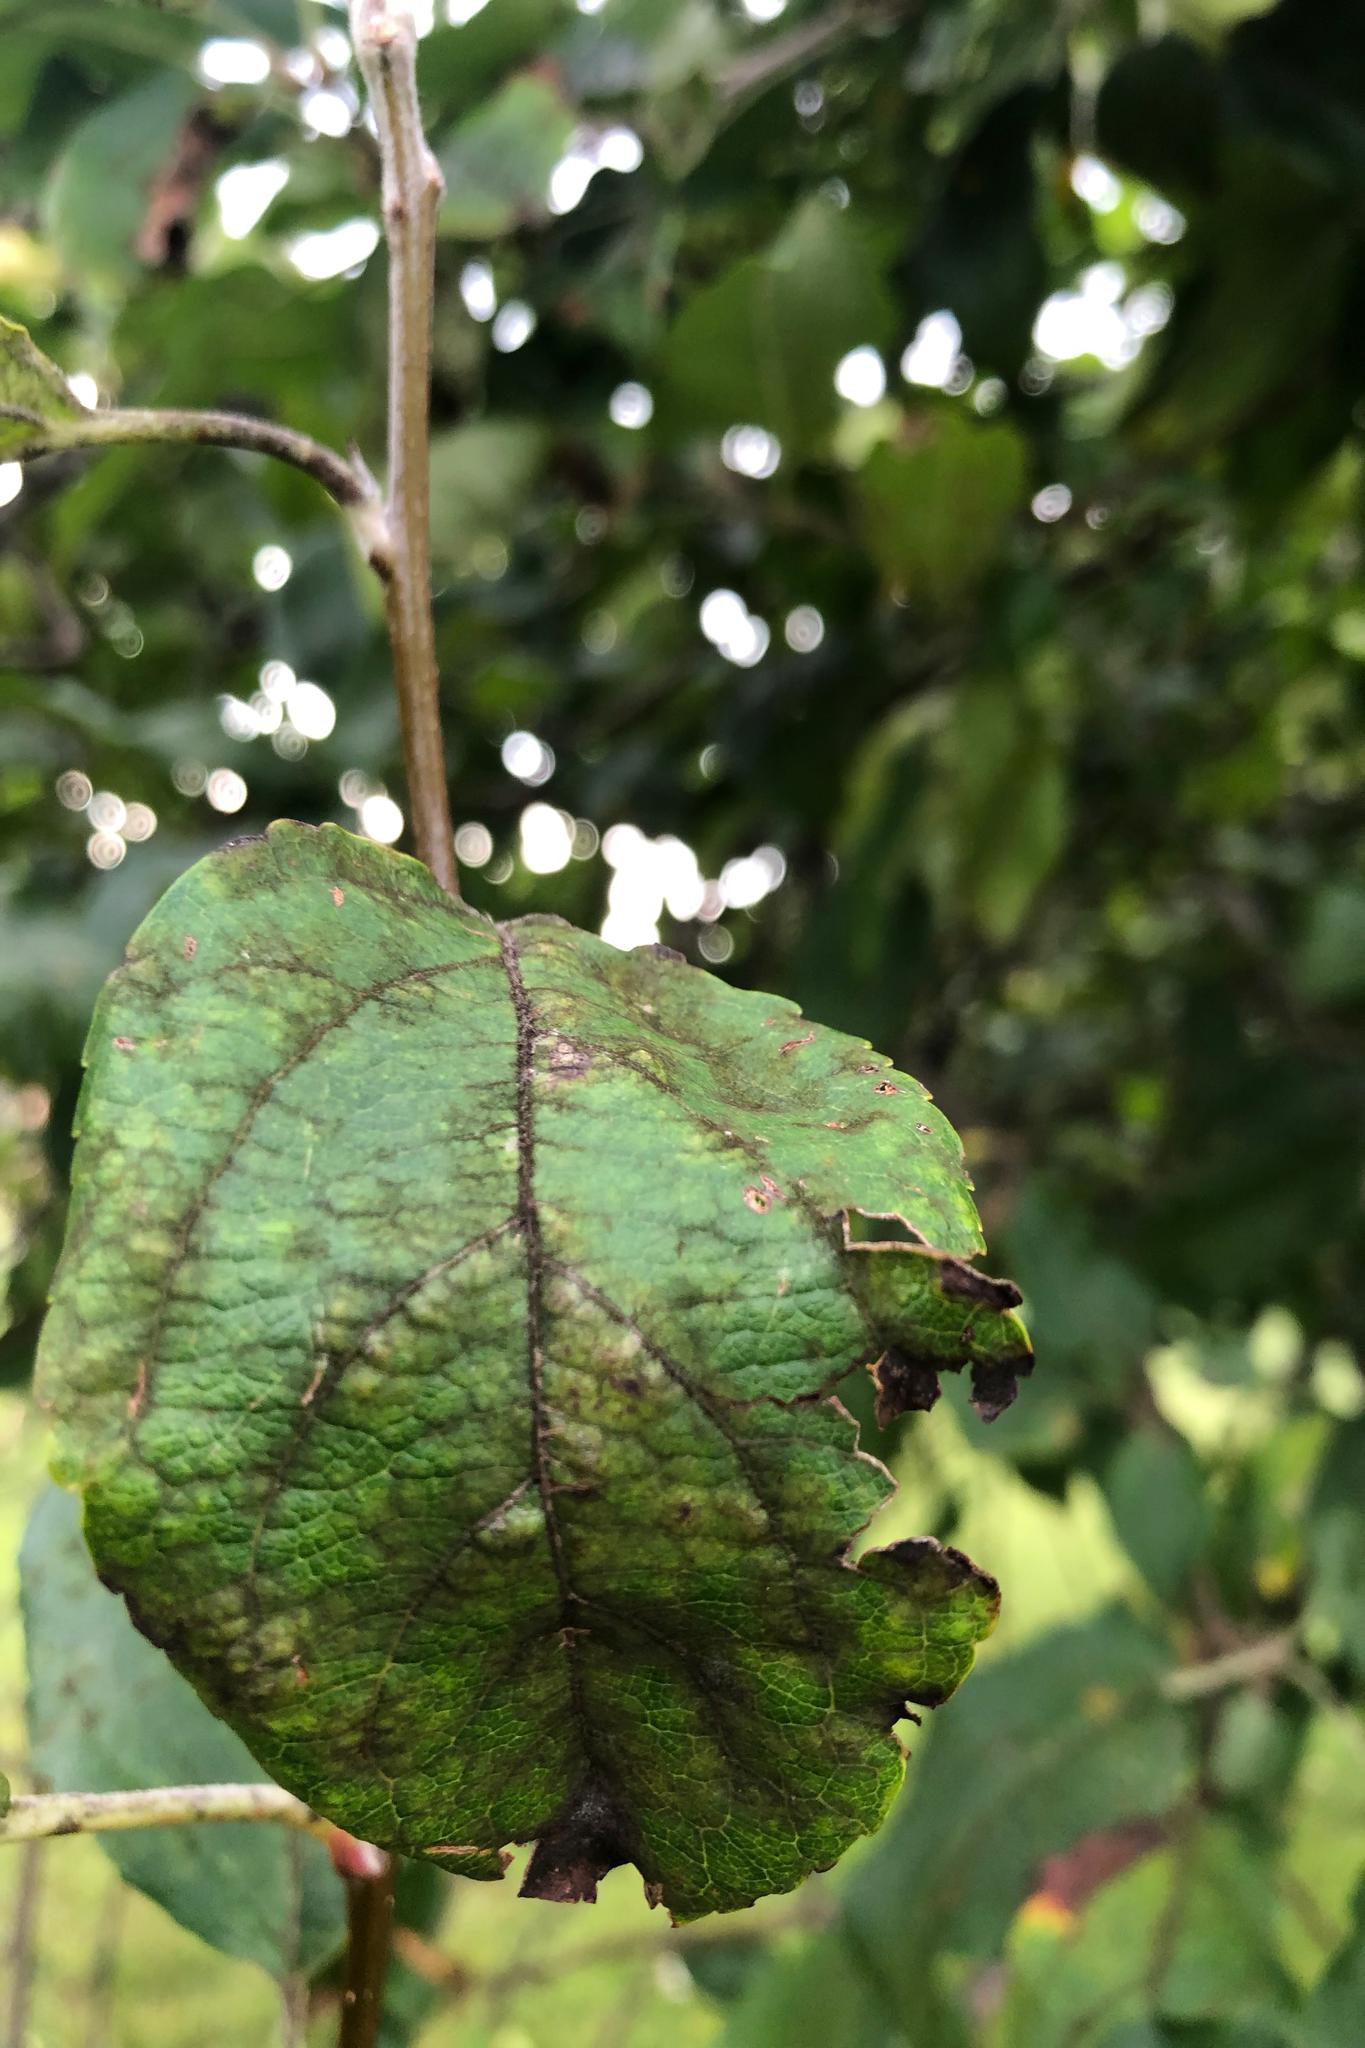

In [28]:
imgs[0]

Clearly the image dimensions of 2048 x 1365 are too big. I'll need to resize the images and the new size can be hyper-param of my feature processor. But for now I'll just create a cache directory and put the resized images in there. Then I won't have to rotate anything.

In [29]:
type(imgs[0])

PIL.JpegImagePlugin.JpegImageFile

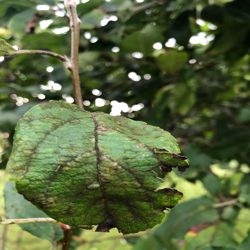

In [30]:
imgs[0].resize((250, 250))

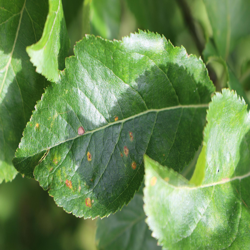

In [31]:
Image.open(path.join(imgroot, "Test_1.jpg")).resize((250, 250))

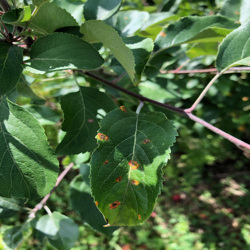

In [32]:
imgs[1].resize((250, 250))

In [37]:
# This function has been moved into training_meta.py for ease of use in feature engineering

def resize_images(height, width):
    cache_root = path.join(DATAROOT, "cache", f"{height}x{width}")
    if path.exists(cache_root):
        raise RuntimeError(f"{cache_root} already exists. Delete the directory and its contents before proceeding.")
    os.mkdir(cache_root)
    
    size = (width, height)
    imgroot = path.join(DATAROOT, "images")
    for img_file in os.listdir(imgroot):
        img_path = path.join(imgroot, img_file)
        resized_img = Image.open(img_path).resize(size)
        resized_img_path = path.join(cache_root, img_file)
        resized_img.save(resized_img_path)

In [38]:
resize_images(height=250, width=250)